In [1]:
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  

print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Memory growth enabled for GPU")

TensorFlow version: 2.8.0
Num GPUs Available:  1
Memory growth enabled for GPU


# Clases

In [28]:
class MammographyDataset:
    
    def __init__(self, data_path):
        self.data_path = data_path
        self.feature_dictionary = {
            'label': tf.io.FixedLenFeature([], tf.int64), # 5 clases - 0 negativo, 1 calcificación benigna, 2 tumor benigno, 3 calcificacion maligna, 4 tumor maligno
            'label_normal': tf.io.FixedLenFeature([], tf.int64), # 2 clases -  0 negativo , 1  positivo
            'image': tf.io.FixedLenFeature([], tf.string)
        }
        self.images = []
        self.labels = []

    #  OBTENCION Y PREPROCESAMIENTO
    def _parse_function(self, example, feature_dictionary=None):
        if feature_dictionary is None:
            feature_dictionary = self.feature_dictionary
        parsed_example = tf.io.parse_single_example(example, feature_dictionary)
        image = tf.io.decode_raw(parsed_example['image'], tf.uint8) # Decodifica el tensor desde su formato binario a un tensor de tipo uint8.
        image = tf.reshape(image, [299, 299, 1]) # Redimensiona la imagen a un tensor de forma [299, 299, 1], es decir, una imagen de 299x299 píxeles con 1 canal (escala de grises).
        image = tf.image.grayscale_to_rgb(image) # Convierte la imagen de un solo canal (escala de grises) a tres canales (RGB).
        image = tf.cast(image, tf.float32) / 255.0 # Convierte el tipo de datos de la imagen a float32 y normaliza los valores de los píxeles al rango [0, 255].
        label = parsed_example['label_normal']
        return image, label

    def load_data(self, filenames):
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=tf.data.experimental.AUTOTUNE)
        dataset = dataset.map(lambda x: self._parse_function(x), num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return dataset

    def explore_dataset(self, dataset):
        labels = []
        for _, label in dataset:
            labels.append(label.numpy())
        labels = tf.convert_to_tensor(labels)
        unique, _, counts = tf.unique_with_counts(labels)
        print("Cantidad de registros por clase: ", dict(zip(unique.numpy(), counts.numpy())))

    def plot_class_distribution(self, dataset):
        labels = []
        for _, label in dataset:
            labels.append(label.numpy())
        labels = tf.convert_to_tensor(labels)
        unique, _, counts = tf.unique_with_counts(labels)
        counts = counts.numpy()
        unique = unique.numpy()
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x=unique, y=counts, palette='viridis')
        plt.title('Distribución de Clases')
        plt.xlabel('Clases')
        plt.ylabel('Cantidad de Registros')
        plt.xticks(ticks=unique, labels=[label_descriptions[label] for label in unique], rotation=45)
        plt.show()

    def data_augmentation(self, image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image, label

    def balance_dataset(self, dataset, target_class_count):
        balanced_datasets = []
        for label in label_descriptions.keys():
            class_dataset = dataset.filter(lambda image, lbl: lbl == label)
            class_count = class_dataset.reduce(0, lambda x, _: x + 1).numpy()
            
            if class_count > target_class_count:
                class_dataset = class_dataset.take(target_class_count)
            else:
                class_dataset = class_dataset.repeat().map(self.data_augmentation).take(target_class_count)
            
            balanced_datasets.append(class_dataset)

        balanced_dataset = balanced_datasets[0]
        for class_dataset in balanced_datasets[1:]:
            balanced_dataset = balanced_dataset.concatenate(class_dataset)
        
        balanced_dataset = balanced_dataset.shuffle(buffer_size=15000)

        return balanced_dataset

    def show_top_5_per_class(self, dataset):
        fig, axes = plt.subplots(len(label_descriptions), 5, figsize=(15, len(label_descriptions) * 3))
        class_counts = {label: 0 for label in label_descriptions.keys()}
        class_images = {label: [] for label in label_descriptions.keys()}

        for image, label in dataset:
            label = label.numpy()
            if class_counts[label] < 5:
                class_images[label].append(image.numpy())
                class_counts[label] += 1
            if all(count == 5 for count in class_counts.values()):
                break

        for lbl, images in class_images.items():
            for i, img in enumerate(images):
                img = img.clip(0, 1)  
                axes[lbl, i].imshow(img)
                axes[lbl, i].axis('off')
            axes[lbl, 2].set_title(label_descriptions[lbl], fontsize=14, y=-0.2)  

        plt.tight_layout()
        plt.show()

        plt.tight_layout()
        plt.show()

    def load_images_labels(self, dataset):
        self.images = []
        self.labels = []
        for image, label in dataset:
            self.images.append(image.numpy())
            self.labels.append(label.numpy())

    #  GRÁFICAS
    def plot_metrics(self, history):
        plt.figure(figsize=(12, 4))
    
        # Precisión
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Precisión de Entrenamiento')
        plt.plot(history.history['val_accuracy'], label='Precisión de Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Precisión')
        plt.legend()
        plt.title('Precisión a lo Largo de las Épocas')
    
        # Pérdida
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Pérdida de Entrenamiento')
        plt.plot(history.history['val_loss'], label='Pérdida de Validación')
        plt.xlabel('Épocas')
        plt.ylabel('Pérdida')
        plt.legend()
        plt.title('Pérdida a lo Largo de las Épocas')
    
        plt.show()

    def plot_confusion_matrix(self, y_true, y_pred, title='Matriz de Confusión', cmap='Blues'):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap=cmap)
        plt.title(title)
        plt.xlabel('Etiqueta Predicha')
        plt.ylabel('Etiqueta Verdadera')
        plt.xticks(ticks=range(len(label_descriptions)), labels=[label_descriptions[label] for label in range(len(label_descriptions))], rotation=45)
        plt.yticks(ticks=range(len(label_descriptions)), labels=[label_descriptions[label] for label in range(len(label_descriptions))], rotation=45)
        plt.show()

    def plot_roc_curve(self, y_true, y_pred_proba, title='Curva ROC'):
        y_true_bin = label_binarize(y_true, classes=list(label_descriptions.keys()))
        n_classes = y_true_bin.shape[1]
        
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])
        
        plt.figure()
        colors = ['aqua', 'darkorange', 'cornflowerblue', 'lime', 'red']
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC clase {label_descriptions[i]} (área = {roc_auc[i]:0.2f})')
        
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Tasa de Falsos Positivos')
        plt.ylabel('Tasa de Verdaderos Positivos')
        plt.title(title)
        plt.legend(loc="lower right")
        plt.show()


# Imports

In [29]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape , BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input

# CLASIFICACIÓN MULTICLASE

## Carga, exploración y preprocesamiento del Dataset

In [6]:
data_path = r"C:\Users\-MSI-\Desktop\Seminario\archive"
dataset_instance = MammographyDataset(data_path)

In [7]:
filenames = [os.path.join(data_path, f"training10_{i}", f"training10_{i}.tfrecords") for i in range(5)]

label_descriptions = {
    0: 'Negativo',
    1: 'Calcificación Benigna',
    2: 'Tumor Benigno',
    3: 'Calcificación Maligna',
    4: 'Tumor Maligno'
}

dataset = dataset_instance.load_data(filenames)
dataset_instance.explore_dataset(dataset)

Cantidad de registros por clase:  {0: 48596, 4: 1812, 3: 1463, 1: 2103, 2: 1911}


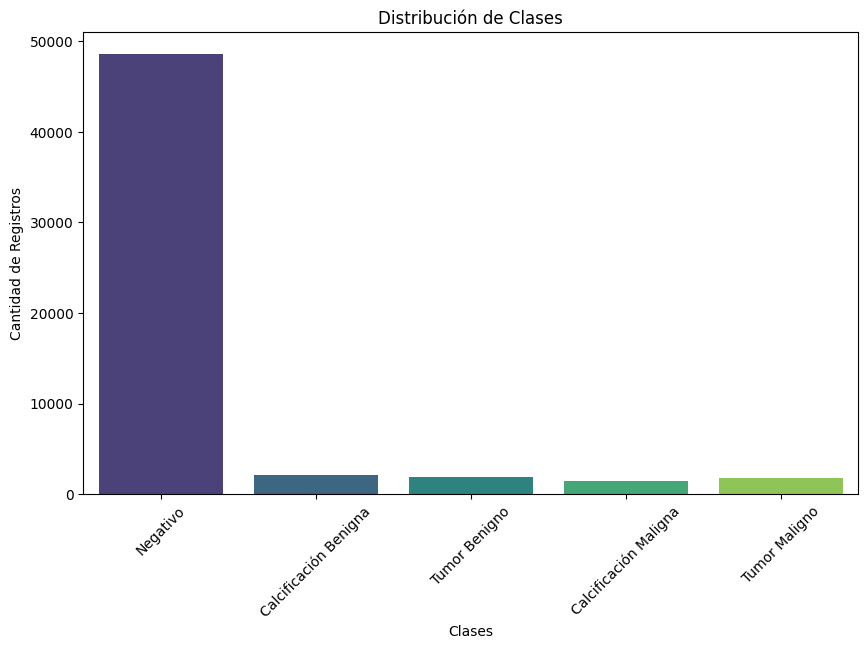

In [8]:
dataset_instance.plot_class_distribution(dataset)

## Undersampling de la clase mayoritaría y Oversampling de las clases minoritarias

Cantidad de registros por clase:  {3: 3000, 1: 3000, 0: 3000, 2: 3000, 4: 3000}


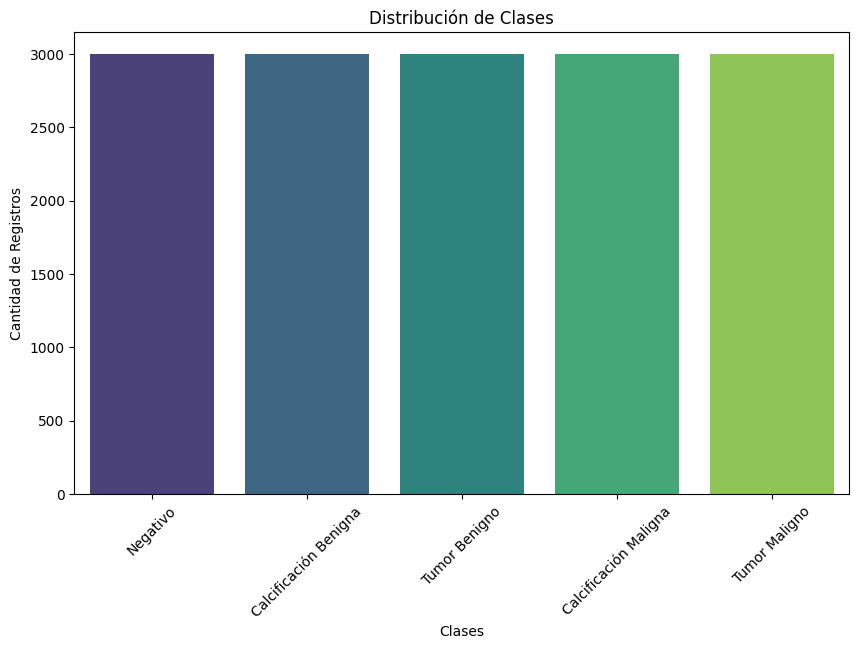

In [9]:
target_class_count = 3000
balanced_dataset = dataset_instance.balance_dataset(dataset, target_class_count)

dataset_instance.explore_dataset(balanced_dataset)
dataset_instance.plot_class_distribution(balanced_dataset)

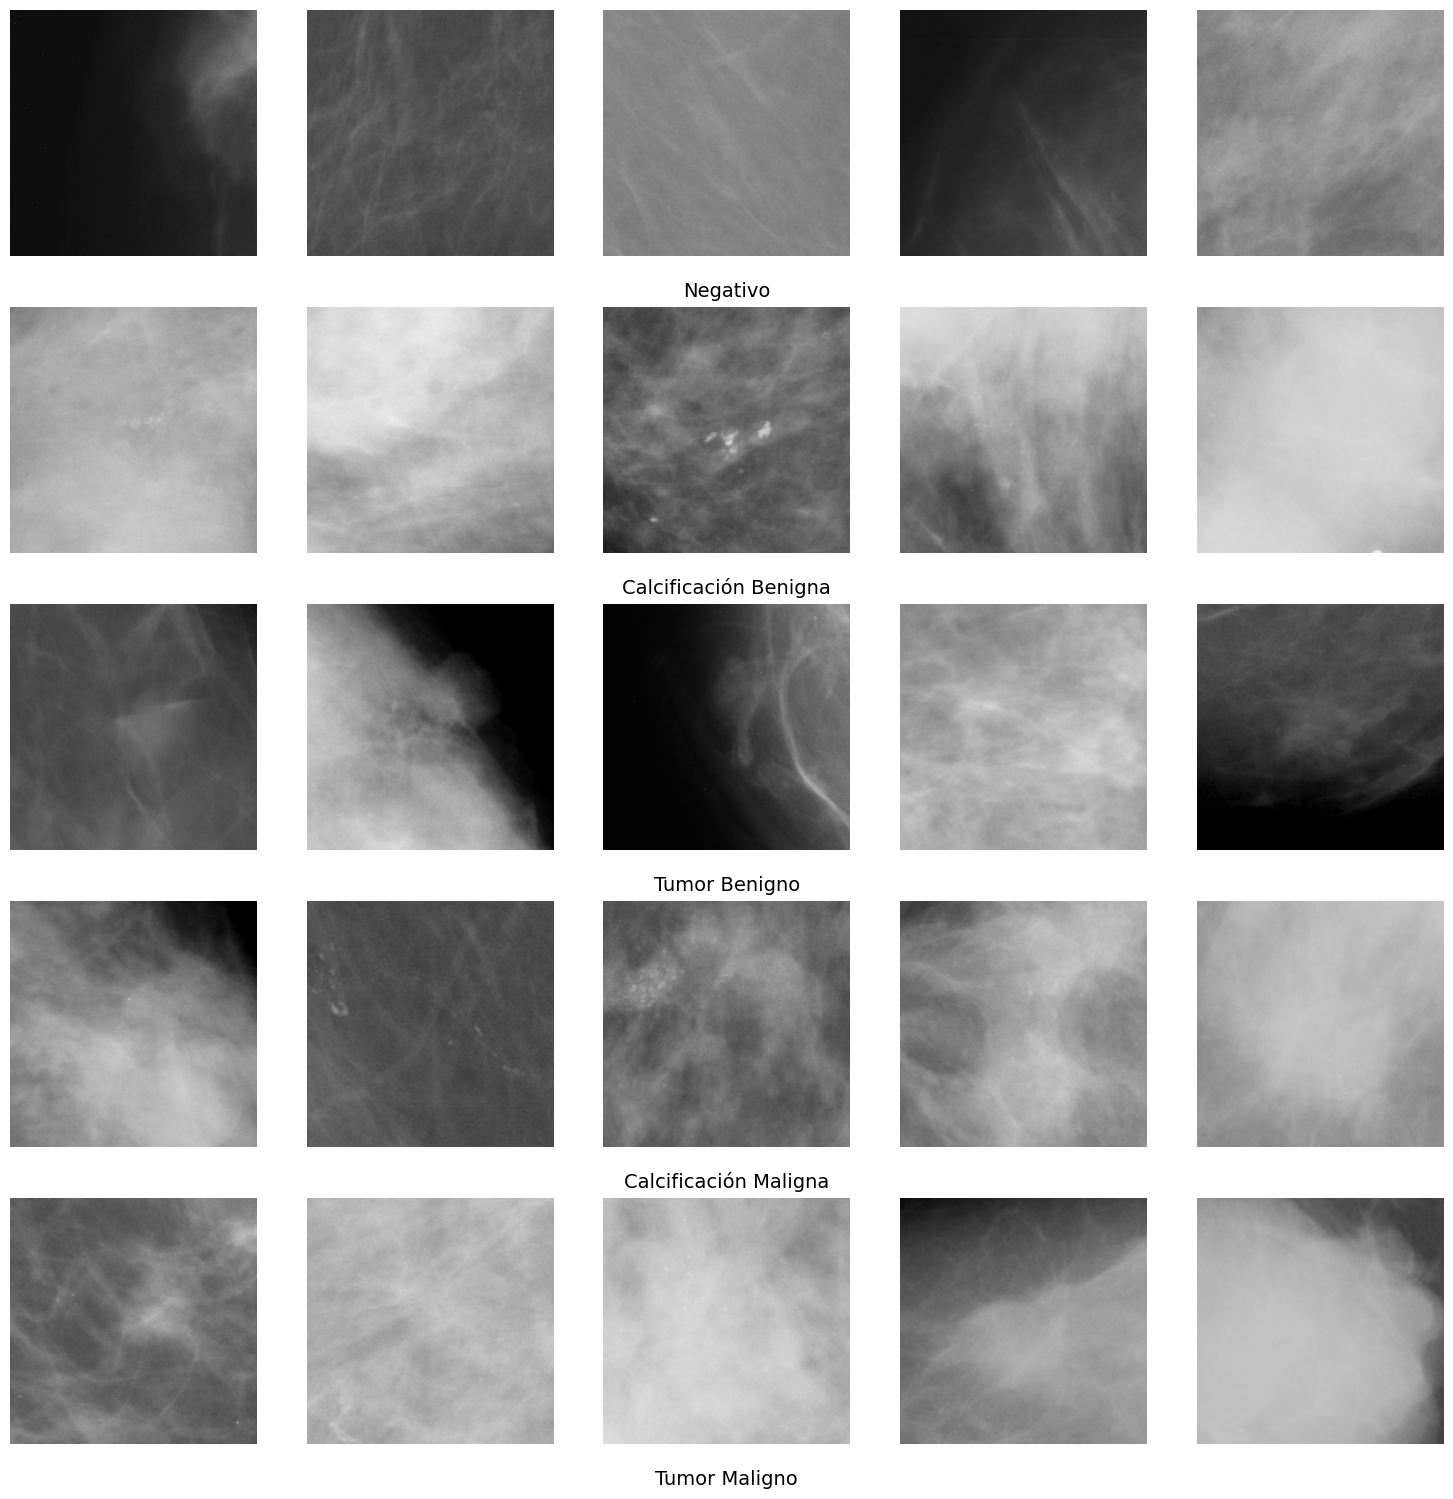

<Figure size 640x480 with 0 Axes>

In [10]:
dataset_instance.show_top_5_per_class(balanced_dataset)

## Division del Dataset en Entrenamiento, Test y Validación

In [11]:
total_size = 15000  # Tamaño total del conjunto de datos balanceado
train_size = int(0.7 * total_size)  # 70% para entrenamiento
val_size = int(0.15 * total_size)   # 15% para validación
test_size = total_size - train_size - val_size  # Resto para prueba

# Verificación de tamaños
print(f"Total: {total_size}, Train: {train_size}, Validation: {val_size}, Test: {test_size}")


Total: 15000, Train: 10500, Validation: 2250, Test: 2250


In [12]:
# Dividir el conjunto de datos
# Primer paso: dividir en entrenamiento y el resto (validación + prueba)
ds_train = balanced_dataset.take(train_size)
ds_test_val = balanced_dataset.skip(train_size)

# Segundo paso: dividir el resto en validación y prueba
ds_val = ds_test_val.take(val_size)
ds_test = ds_test_val.skip(val_size)

Distribución de clases en el conjunto de entrenamiento:


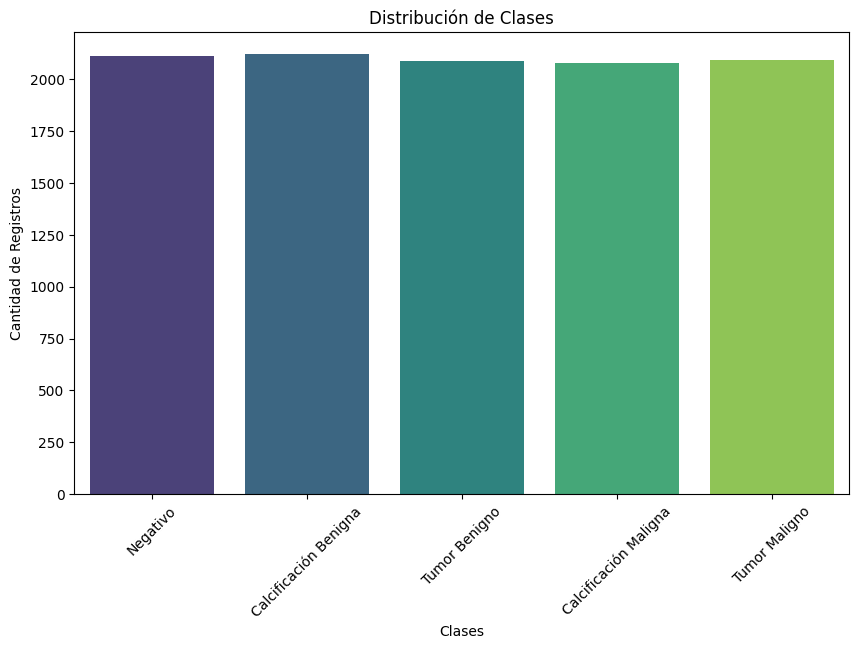

Distribución de clases en el conjunto de validación:


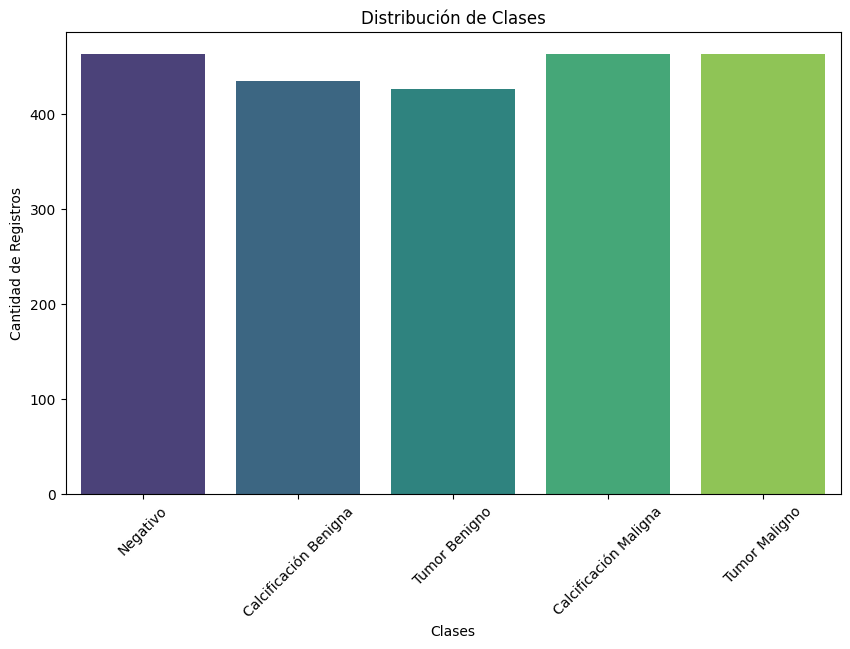

Distribución de clases en el conjunto de prueba:


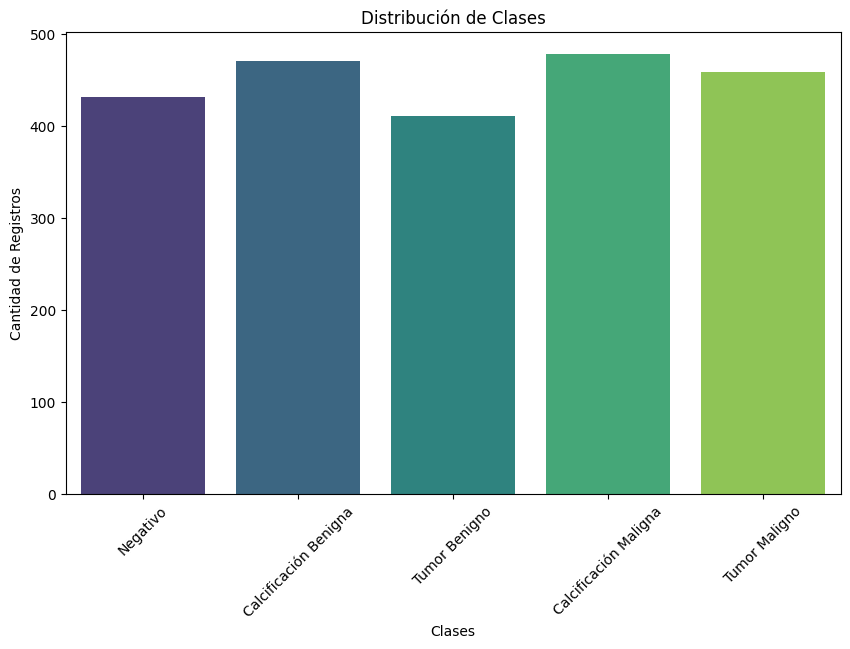

In [13]:
print("Distribución de clases en el conjunto de entrenamiento:")
dataset_instance.plot_class_distribution(ds_train)
print("Distribución de clases en el conjunto de validación:")
dataset_instance.plot_class_distribution(ds_val)
print("Distribución de clases en el conjunto de prueba:")
dataset_instance.plot_class_distribution(ds_test)

In [14]:
batch_size = 32

ds_train = ds_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [15]:
os.environ['TF_ENABLE_GPU_GARBAGE_COLLECTION'] = 'false'
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [16]:
def create_rnn_model(input_shape, num_classes):
    model = Sequential([
         # 3 Capas Convolucionales con MaxPooling y Regularización l2
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        
        # Capa Densa con Dropout
        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        BatchNormalization(),
        Dropout(0.5),
        
        # Capa de Salida
        Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
# Parámetros del modelo
input_shape = (299, 299, 3)
num_classes = 5

# Crear el modelo
model_rnn = create_rnn_model(input_shape, num_classes)

# Definir callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

# Entrenamiento del modelo
history_rnn = model_rnn.fit(
    ds_train,
    epochs=50,
    validation_data=ds_val,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
329/329 [==============================] - 238s 428ms/step - loss: 5.9734 - accuracy: 0.3249 - val_loss: 2.9724 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/50
329/329 [==============================] - 245s 427ms/step - loss: 2.7070 - accuracy: 0.3302 - val_loss: 2.4355 - val_accuracy: 0.3324 - lr: 0.0010
Epoch 3/50
329/329 [==============================] - 240s 431ms/step - loss: 2.2924 - accuracy: 0.3462 - val_loss: 2.1752 - val_accuracy: 0.3053 - lr: 0.0010
Epoch 4/50
329/329 [==============================] - 239s 424ms/step - loss: 2.1509 - accuracy: 0.3570 - val_loss: 2.2142 - val_accuracy: 0.2684 - lr: 0.0010
Epoch 5/50
329/329 [==============================] - 240s 427ms/step - loss: 2.1967 - accuracy: 0.3557 - val_loss: 2.2927 - val_accuracy: 0.2693 - lr: 0.0010
Epoch 6/50
329/329 [==============================] - 239s 427ms/step - loss: 2.2312 - accuracy: 0.3636 - val_loss: 2.2652 - val_accuracy: 0.3578 - lr: 0.0010


In [21]:
# Evaluar el modelo
y_true = np.concatenate([y for _, y in ds_test], axis=0)

y_pred_rnn = model_rnn.predict(ds_test)
y_pred_classes_rnn = np.argmax(y_pred_rnn, axis=1)  # Convierte probabilidades a etiquetas de clase

# Calcular métricas detalladas por clase
print(classification_report(y_true, y_pred_classes_rnn, target_names=[label_descriptions[label] for label in sorted(label_descriptions.keys())]))

                       precision    recall  f1-score   support

             Negativo       0.20      0.22      0.21       433
Calcificación Benigna       0.21      0.43      0.28       444
        Tumor Benigno       0.22      0.11      0.15       501
Calcificación Maligna       0.21      0.25      0.23       454
        Tumor Maligno       0.21      0.02      0.04       418

             accuracy                           0.21      2250
            macro avg       0.21      0.21      0.18      2250
         weighted avg       0.21      0.21      0.18      2250



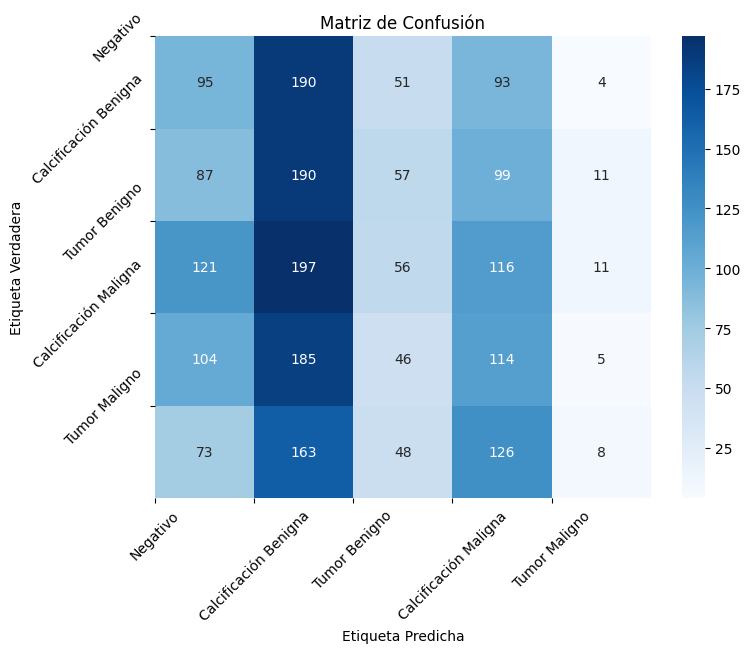

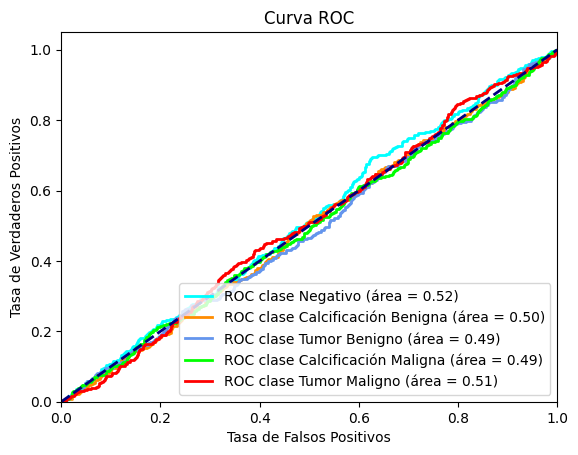

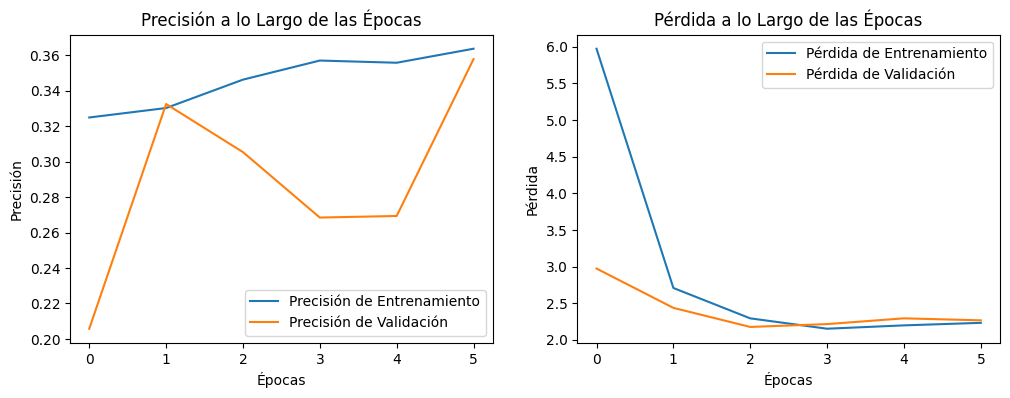

In [22]:
# Graficar métricas
dataset_instance.plot_confusion_matrix(y_true, y_pred_classes_rnn)
dataset_instance.plot_roc_curve(y_true, y_pred_rnn)
dataset_instance.plot_metrics(history_rnn)

## Construcción y Entrenamiento del Modelo Tradicional - SVM + ResNet50

In [11]:
# Modelo preentrenado ResNet50 sin la última capa (top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# GlobalAveragePooling2D para reducir la dimensionalidad
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Predecir y extraer características con el modelo
def extract_features(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # Aplicar preprocess_input específico de ResNet50
        processed_images = preprocess_input(images.numpy())
        features = model.predict(processed_images)
        all_features.append(features)
        all_labels.append(labels.numpy())  # Convertir labels a numpy si es necesario
    return np.concatenate(all_features), np.concatenate(all_labels)

# Preparación de los datasets
ds_train = ds_train.map(lambda x, y: (preprocess_input(x), y))
ds_val = ds_val.map(lambda x, y: (preprocess_input(x), y))
ds_test = ds_test.map(lambda x, y: (preprocess_input(x), y))

# Extracción de características para cada conjunto de datos
features_train, y_train = extract_features(ds_train)
features_val, y_val = extract_features(ds_val)
features_test, y_test = extract_features(ds_test)

In [12]:
# Configuración del clasificador SVM
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Entrenamiento
history_svm = svm_clf.fit(features_train, y_train)

In [13]:
# Predicción
y_pred = svm_clf.predict(features_val)
y_pred_proba = svm_clf.predict_proba(features_val)

In [14]:
class_names = [label_descriptions[label] for label in sorted(label_descriptions.keys())]

print(classification_report(y_val, y_pred, target_names=class_names))

                       precision    recall  f1-score   support

             Negativo       0.68      0.78      0.73       476
Calcificación Benigna       0.43      0.48      0.46       430
        Tumor Benigno       0.46      0.47      0.46       432
Calcificación Maligna       0.46      0.42      0.44       464
        Tumor Maligno       0.59      0.48      0.53       448

             accuracy                           0.53      2250
            macro avg       0.52      0.53      0.52      2250
         weighted avg       0.53      0.53      0.53      2250



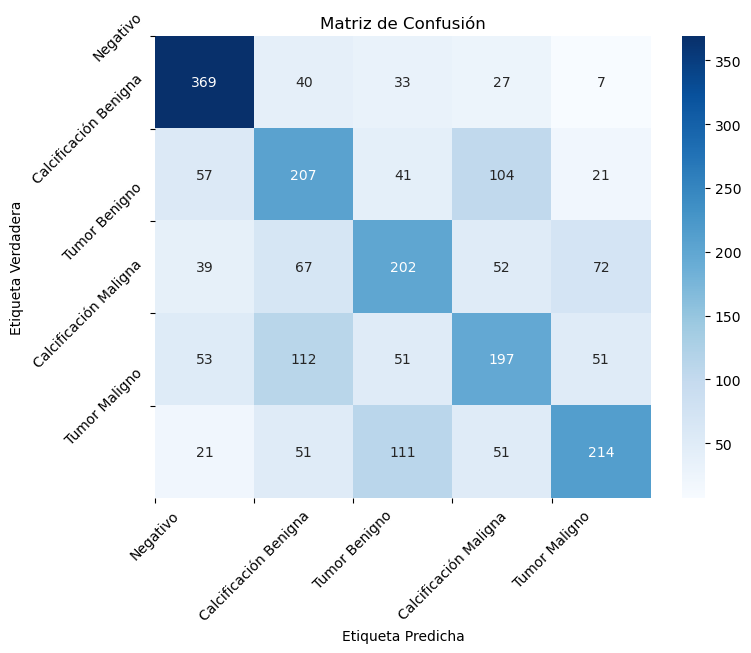

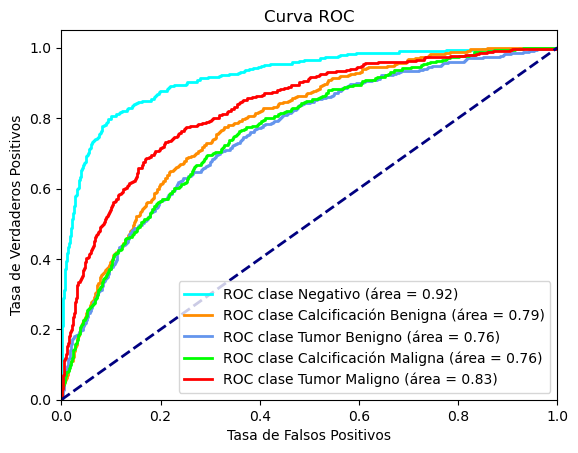

In [16]:
dataset_instance.plot_confusion_matrix(y_val, y_pred)
dataset_instance.plot_roc_curve(y_val, y_pred_proba)
#dataset_instance.plot_metrics(history_svm)

# CLASIFICACIÓN BINARIA

## Carga, exploración y preprocesamiento del Dataset

In [30]:
data_path = r"C:\Users\-MSI-\Desktop\Seminario\archive"
dataset_instance_binaria = MammographyDataset(data_path)

In [31]:
filenames = [os.path.join(data_path, f"training10_{i}", f"training10_{i}.tfrecords") for i in range(5)]

label_descriptions = {
    0: 'Negativo',
    1: 'Positivo'
}

dataset = dataset_instance_binaria.load_data(filenames)
dataset_instance_binaria.explore_dataset(dataset)

Cantidad de registros por clase:  {0: 48596, 1: 7289}


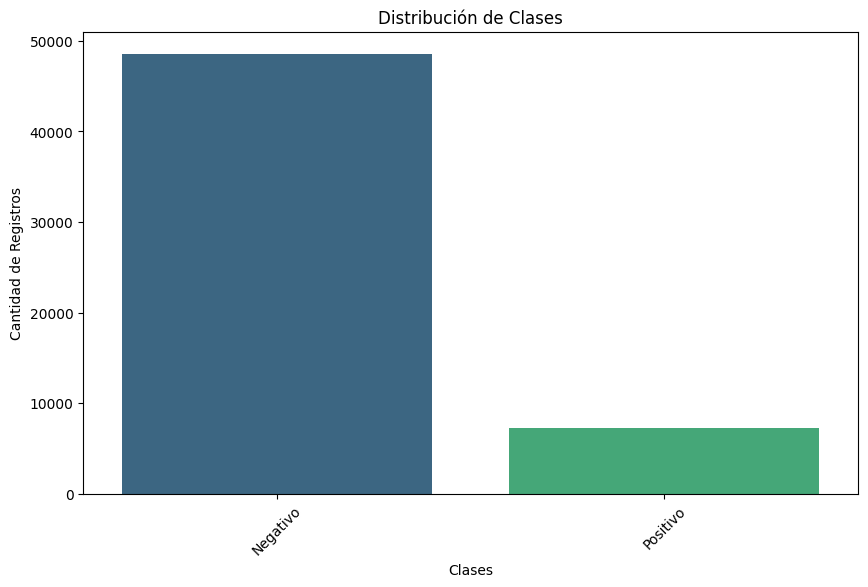

In [32]:
dataset_instance_binaria.plot_class_distribution(dataset)

## Undersampling de la clase mayoritaría 

Cantidad de registros por clase:  {0: 7289, 1: 7289}


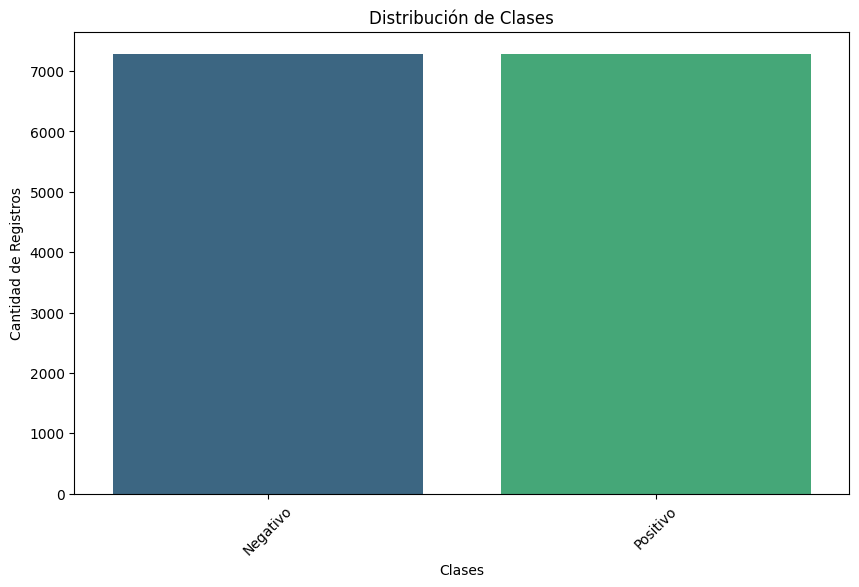

In [34]:
target_class_count = 7289
balanced_dataset = dataset_instance_binaria.balance_dataset(dataset, target_class_count)

dataset_instance_binaria.explore_dataset(balanced_dataset)
dataset_instance_binaria.plot_class_distribution(balanced_dataset)

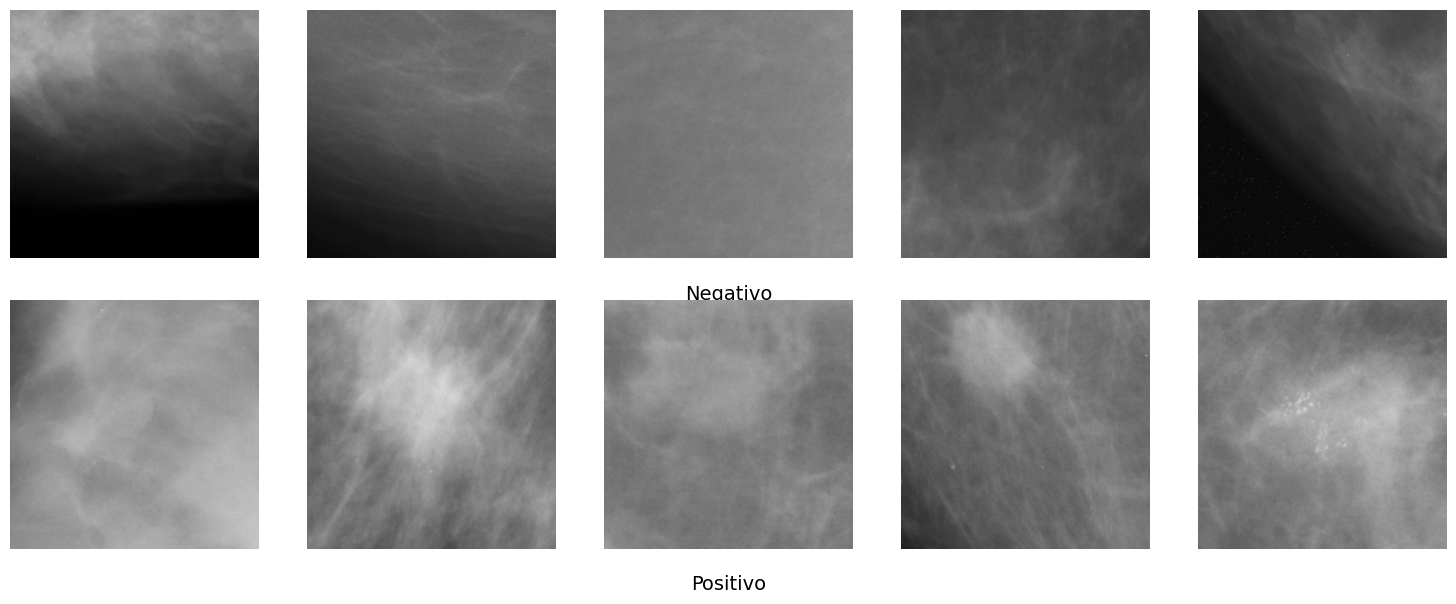

<Figure size 640x480 with 0 Axes>

In [35]:
dataset_instance_binaria.show_top_5_per_class(balanced_dataset)

## Division del Dataset en Entrenamiento, Test y Validación

In [36]:
total_size = 14578  # Tamaño total del conjunto de datos balanceado
train_size = int(0.7 * total_size)  # 70% para entrenamiento
val_size = int(0.15 * total_size)   # 15% para validación
test_size = total_size - train_size - val_size  # Resto para prueba

# Verificación de tamaños
print(f"Total: {total_size}, Train: {train_size}, Validation: {val_size}, Test: {test_size}")

Total: 14578, Train: 10204, Validation: 2186, Test: 2188


In [37]:
# Dividir el conjunto de datos
# Primer paso: dividir en entrenamiento y el resto (validación + prueba)
ds_train = balanced_dataset.take(train_size)
ds_test_val = balanced_dataset.skip(train_size)

# Segundo paso: dividir el resto en validación y prueba
ds_val = ds_test_val.take(val_size)
ds_test = ds_test_val.skip(val_size)

Distribución de clases en el conjunto de entrenamiento:


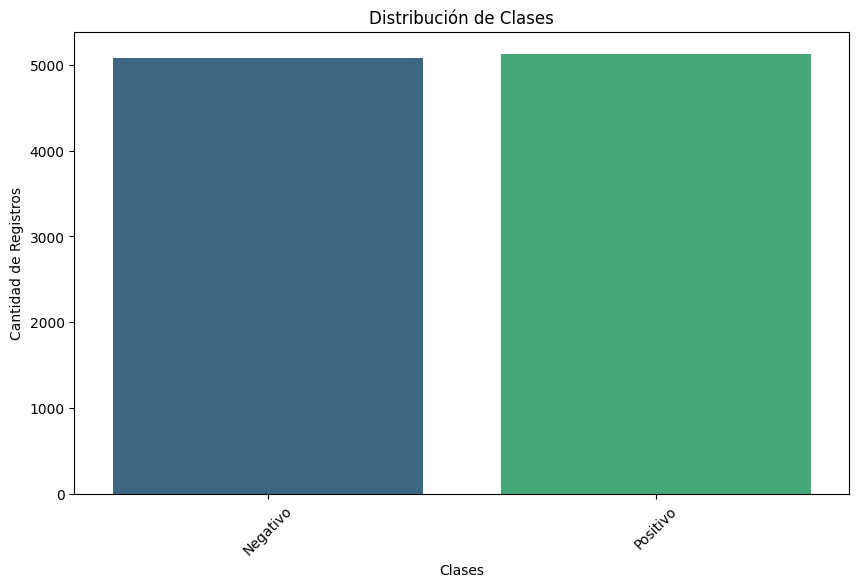

Distribución de clases en el conjunto de validación:


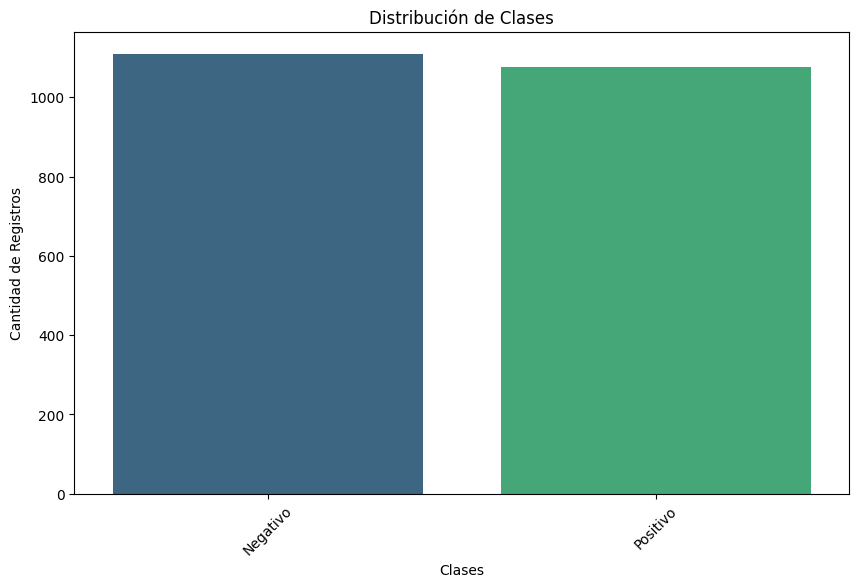

Distribución de clases en el conjunto de prueba:


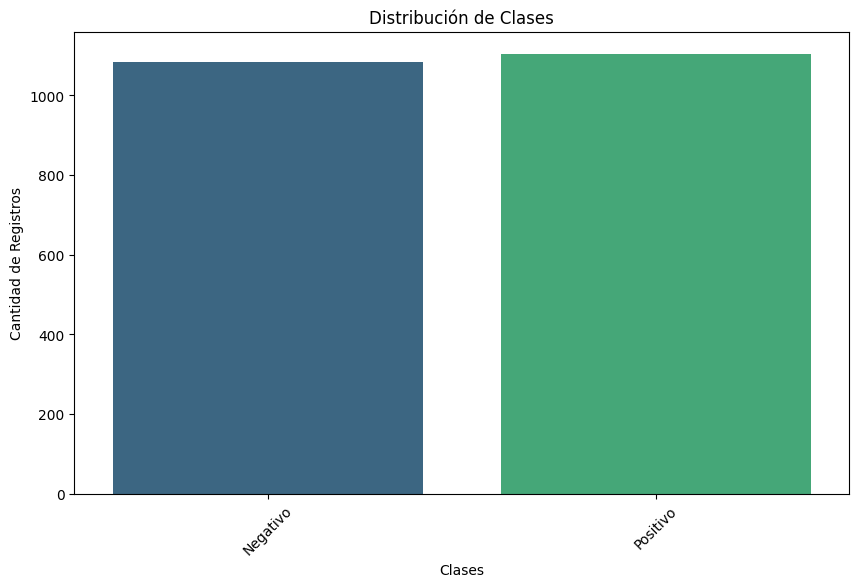

In [38]:
print("Distribución de clases en el conjunto de entrenamiento:")
dataset_instance_binaria.plot_class_distribution(ds_train)
print("Distribución de clases en el conjunto de validación:")
dataset_instance_binaria.plot_class_distribution(ds_val)
print("Distribución de clases en el conjunto de prueba:")
dataset_instance_binaria.plot_class_distribution(ds_test)

In [39]:
batch_size = 32

ds_train = ds_train.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

## Construcción y Entrenamiento del Modelo Tradicional - SVM + ResNet50

In [40]:
# Modelo preentrenado ResNet50 sin la última capa (top)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
# GlobalAveragePooling2D para reducir la dimensionalidad
model = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Predecir y extraer características con el modelo
def extract_features(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        # Aplicar preprocess_input específico de ResNet50
        processed_images = preprocess_input(images.numpy())
        features = model.predict(processed_images)
        all_features.append(features)
        all_labels.append(labels.numpy())  # Convertir labels a numpy si es necesario
    return np.concatenate(all_features), np.concatenate(all_labels)

# Preparación de los datasets
ds_train = ds_train.map(lambda x, y: (preprocess_input(x), y))
ds_val = ds_val.map(lambda x, y: (preprocess_input(x), y))
ds_test = ds_test.map(lambda x, y: (preprocess_input(x), y))

# Extracción de características para cada conjunto de datos
features_train, y_train = extract_features(ds_train)
features_val, y_val = extract_features(ds_val)
features_test, y_test = extract_features(ds_test)

In [41]:
# Configuración del clasificador SVM
svm_clf = make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True))

# Entrenamiento
history_svm = svm_clf.fit(features_train, y_train)

In [42]:
# Predicción
y_pred = svm_clf.predict(features_val)
y_pred_proba = svm_clf.predict_proba(features_val)

In [43]:
class_names = [label_descriptions[label] for label in sorted(label_descriptions.keys())]

print(classification_report(y_val, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negativo       0.85      0.84      0.85      1112
    Positivo       0.84      0.85      0.84      1074

    accuracy                           0.85      2186
   macro avg       0.85      0.85      0.85      2186
weighted avg       0.85      0.85      0.85      2186



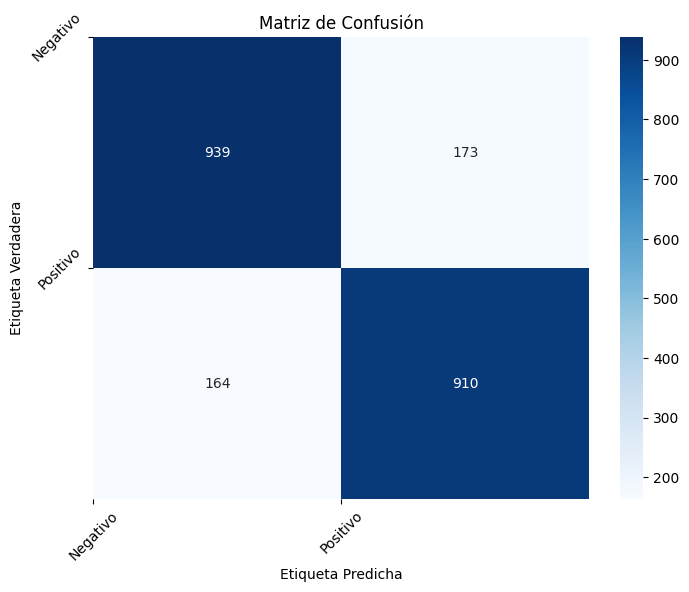

In [46]:
dataset_instance_binaria.plot_confusion_matrix(y_val, y_pred)

In [55]:
y_true = np.concatenate([y for _, y in ds_test], axis=0)

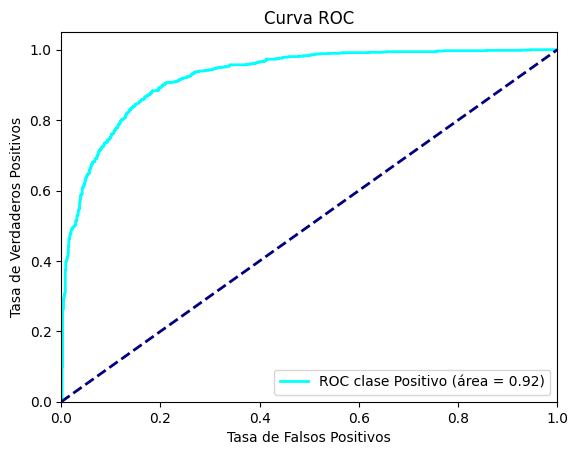

In [59]:
def plot_roc_curve(y_true, y_pred_proba, title='Curva ROC'):
    # Si tienes clases binarias
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    plt.plot(fpr, tpr, color='aqua', lw=2, label=f'ROC clase Positivo (área = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(y_val, y_pred_proba)

# Guardado del modelo binario

In [60]:
import joblib

joblib.dump(svm_clf, 'svm_model.pkl')

['svm_model.pkl']

In [62]:
from joblib import dump, load
dump(svm_clf, 'svm_model.joblib')

['svm_model.joblib']

# Conclusiones y Trabajo Futuro